# ML Predictive Modeling - Purchase Incidence & Price Elasticity of Purchase Probability by Segment


$\hookrightarrow$ **Will a customer buy a product from a particular product category when they enter the shop?**

We will arrive at the answer using a statistical model logistic regression that estimates purchase probability for each customer at each shopping trip. We use Logistic Regression because it is a neat and straightforward approach which can be easily interpreted. Then, we'll calculate the price elasticity of purchase probability under different conditions.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set_style("whitegrid")

## Data Preparation

In [2]:
#load data
df_purchase = pd.read_csv('DATA/purchase data.csv')

# Import pickle models
scaler = pickle.load(open('Models/00-scaler.pickle', 'rb'))
pca = pickle.load(open('Models/01-pca.pickle', 'rb'))
kmeans_pca = pickle.load(open('Models/02-kmeans_pca.pickle', 'rb'))

# Filter dataframe to 7 features
features = df_purchase[['Sex', 'Marital status',
                        'Age', 'Education', 'Income',
                        'Occupation', 'Settlement size']]
# Standardization
df_purchase_segm_std = scaler.transform(features)

# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the dataframe
df_purchase_predictors = df_purchase.copy()

# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca,
                                 prefix = 'Segment',
                                 prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies],
                                   axis = 1)
# Set name to full dataframe
df_pa = df_purchase_predictors

## Purchase Probability Model - Logistic Regression

We want to know whether a purchase has happened based on the average price of a product. Though there are different brands of candy bars right now, **we are only interested in whether a purchase will occur at all**. With that in mind, let's create a variable representing price irrespective of the brand.

We have a few options here. We can take the minimum or maximum price, which are good indicators of how expensive a product is in general. For instance, a brand new iPhone would be in the range between 400.0 and 1.000 dollars (both the minimum price and the maximum price are indicative here) or in another case imagine a house, on the contrary, would not cost less than 5.000, 10.000 or 50.000 dollars, depending on a variety of factors, however, its maximum price may be in the millions of dollars (maybe a maximum price here would not be as useful).

Other useful measures are **mean price and median price, these two are the two most common ways to represent an average, this model quantifies the exact relationship between price and probability of purchase**.

In [3]:
# Set input and output variables
y = df_pa['Incidence']

X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

X

,Mean_Price
0,2.044
1,2.028
2,2.028
3,2.028
4,2.030
...,...
58688,2.060
58689,2.060
58690,2.086
58691,2.092


In [4]:
# Logistic regression model
# solver='sag', is optimal for simple problems with large datasets like this one

model_purchase = LogisticRegression(solver='sag')
model_purchase.fit(X, y)

LogisticRegression(solver='sag')

In [5]:
# The coefficients for price interpretation

for i in model_purchase.coef_:
    if i < 0:
        print(f"Price Coefficient Value = {i[0]:.5f}\n")
        print("Interpretation of Coefficient:\nThe coefficients for price,", 
              "is negative signals that, with an increase in price,\t",
              "the purchase probability decreases",
              end=" ")
    else:
        print(f"Price Coefficient Value = {i[0]:.5f}\n")
        print("""The coefficients for price, is positive, signals that,
            with an increase in price, the purchase probability increases""")

Price Coefficient Value = -2.34794

Interpretation of Coefficient:
The coefficients for price, is negative signals that, with an increase in price,	 the purchase probability decreases 

## Calculate Price Elasticity of Purchase Probability


We just estimated our logistic regression model and now we can use the results to calculate the price elasticity of purchase probability.


> **TIP**: The Price Elasticity of Purchase Probability is the percentage change in purchase probability and response to a 1% change in price for the product category.



We have information about the change in purchase probability, given a price, that's what the logistic regression coefficient is showing. Therefore, we want to check different values for the mean price and see how they affect the purchase probability.

Since we are programming, we can define a range of prices and analyze each one of them. It is most logical to see the range of prices available in our data set first, lo let's apply the `.describe()` on out dataframe to examine the limits of our dataset.


In [6]:
# Prices for the five different brands, important in determining purchase probability 
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe().T

,count,mean,std,min,25%,50%,75%,max
Price_1,58693.0,1.392074,0.091139,1.10,1.34,1.39,1.47,1.59
Price_2,58693.0,1.780999,0.170868,1.26,1.58,1.88,1.89,1.90
Price_3,58693.0,2.006789,0.046867,1.87,1.97,2.01,2.06,2.14
Price_4,58693.0,2.159945,0.089825,1.76,2.12,2.17,2.24,2.26
Price_5,58693.0,2.654798,0.098272,2.11,2.63,2.67,2.70,2.80


In [7]:
# Set price range for which we'll examine the purchase probability (step 1 cent)
price_range = np.arange(0.5, 3.5, 0.01)

# Save price range in a dataframe
df_price_range = pd.DataFrame(price_range)
df_price_range.shape

(300, 1)

$$\textit{Purchase Probability Elasticity (E)} = \frac{\frac{\Delta Pr(purchase)}{Pr(purchase)}}{\frac{\Delta Price}{Price}} = \frac{\Delta Pr(purchase)}{\Delta Price}·\frac{Price}{Pr(purchase)}$$

$$\Rightarrow E = \beta · Price · (1 - Pr(purchase))$$

In [8]:
# Predict the purchase probability for defined price range
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [9]:
# Create price elasticities (pe) dataframe contain all the elasticities
df_price_elasticities = pd.DataFrame(price_range)

df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe

df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096414
1,0.51,-0.100483
2,0.52,-0.104679
3,0.53,-0.109004
4,0.54,-0.113463
...,...,...
295,3.45,-8.012504
296,3.46,-8.037752
297,3.47,-8.062966
298,3.48,-8.088147


## Analyze the Results of Price Elasticity of Purchase Probability

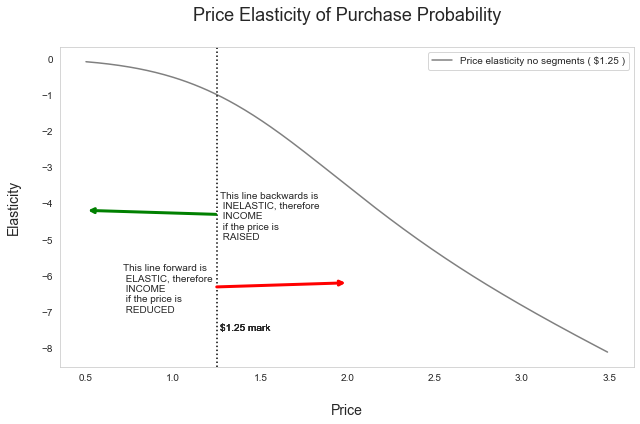

In [43]:
# Plot price elasticity of purchase probability of the average customer
# We observe that the price elasticities are all negative

plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.axvline(1.25, **{'lw': 1.5, 'alpha': 1, 'ls': ':', 'color': 'black'})
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

# Mark down (bold effect)
plt.annotate('$1.25 mark', xy=(1.22, -7.5) ,xytext=(1.27, -7.5))
plt.annotate('$1.25 mark', xy=(1.22, -0.5) ,xytext=(1.27, -7.5))
plt.annotate('$1.25 mark', xy=(1.22, -0.5) ,xytext=(1.27, -7.5))
plt.annotate('$1.25 mark', xy=(1.22, -0.5) ,xytext=(1.27, -7.5))

# Increase price line
plt.annotate(
# Label and coordinate
    'This line backwards is\n INELASTIC, therefore\n INCOME\n if the price is\n RAISED',
    xy=(0.5, -4.2), xytext=(1.27, -5),
    # Custom arrow
    arrowprops=dict(arrowstyle='->',lw=3, color='green'))

# Reduce price line    
plt.annotate(
    # Label and coordinate
    'This line forward is\n ELASTIC, therefore\n INCOME\n if the price is\n REDUCED',
    xy=(2, -6.20), xytext=(0.71, -7),
    # Custom arrow
    arrowprops=dict(arrowstyle='->',lw=3, color='red'))

plt.tight_layout()
plt.legend()
plt.grid(False)
plt.show()

We can see the entire elasticity curve and how it changes compared to the price range as a function, the price elasticity decreases as price increases, meaning the higher the price of a product becomes, the less likely it will be for people to want to buy it.


**What is interesting, though, is at what rate this happens**. Let's see, the decrease in price is slow in the range between zero point five and one point one, and then it becomes steeper after the one point one mark. The other important observation we make is that the price elasticities are all negative.


By definition, **elasticity measures the percent change in an output variable, in our case purchase probability, given a percent change in an input variable or in our case, price**. Now, **if this percent change is greater than 100 percent, we say that the output or purchase probability is called elastic**.

On the other hand, **for changes less than 100 percent, it is inelastic**. In other words, if the elasticity has a value smaller than one, in absolute terms, we say it is inelastic. If it is greater than one, we say it is elastic.

In this case, **the elasticity of purchase probability is elastic**. This is an important distinction, and the reason is that **for inelastic values, the general recommendation is to increase the price** as it wouldn't cause a significant decrease in the output variable or in our case, purchase probability. On the other hand, **if we have the elasticity, which is greater than one in absolute terms, we should decrease our prices**.


> **TIP**: If is elastic, recommended to lower price, if inelastic, recommended to increase prices.



Now that we've elaborated on that, we can find the price elasticities which are elastic and the ones which are inelastic, the elasticity is steadily decreasing. Therefore, in our graph, it starts from being inelastic and then switches to being elastic.

Let's track down the precise point at which this happens, from the table we observed this happens at the 1.25 mark (price elastisity = -1.0).



And that brings us to the following **conclusion**:
1. For prices lower than 1.25, we can increase our product price without losing too much in terms of purchase probability.
2. For prices higher than 1.25 we have more to gain by reducing our prices.


The next step is to take advantage that we have segmented our customers dataset, so we'll see how to estimate the purchase elasticities for the different segments.

## Purchase Probability by Segments

### $\hookrightarrow \color{blue} {\text{Segment 0 - Standard}}$

In [11]:
# Select only customers from segment 0 
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]

# Prepare dependant and independant variables.
y = df_pa_segment_0['Incidence']
X = pd.DataFrame()
# Calculate average price segment 0
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5

# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver='sag')
model_incidence_segment0.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment0.coef_

# Predict purchase probability
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment0)
# Save values in hte dataframe
df_price_elasticities['PE_Segment_0'] = pe_segment0
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0
0,0.50,-0.096414,-0.211212
1,0.51,-0.100483,-0.217785
2,0.52,-0.104679,-0.224464
3,0.53,-0.109004,-0.231253
4,0.54,-0.113463,-0.238151
...,...,...,...
295,3.45,-8.012504,-5.053260
296,3.46,-8.037752,-5.070120
297,3.47,-8.062966,-5.086960
298,3.48,-8.088147,-5.103783


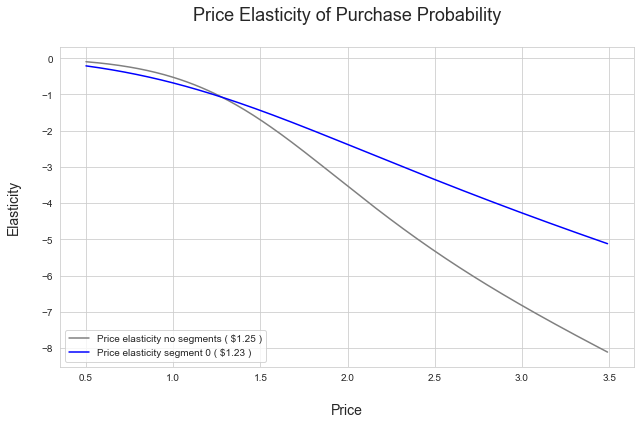

In [12]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

### $\hookrightarrow \color{green} {\text{Segment 1 - Career-Focused}}$

In [13]:
# Select only customers from segment 1 
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

# Prepare dependant and independant variables.
y = df_pa_segment_1['Incidence']
X = pd.DataFrame()
# Calculate average price segment 1
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

# Logistic regression model
model_incidence_segment1 = LogisticRegression(solver='sag')
model_incidence_segment1.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment1.coef_

# Predict purchase probability
Y_segment_1 = model_incidence_segment1.predict_proba(df_price_range)
purchase_pr_segment1 = Y_segment_1[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment1 = model_incidence_segment1.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment1)
# Save values in the dataframe
df_price_elasticities['PE_Segment_1'] = pe_segment1
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1
0,0.50,-0.096414,-0.211212,-0.119103
1,0.51,-0.100483,-0.217785,-0.123286
2,0.52,-0.104679,-0.224464,-0.127561
3,0.53,-0.109004,-0.231253,-0.131932
4,0.54,-0.113463,-0.238151,-0.136398
...,...,...,...,...
295,3.45,-8.012504,-5.053260,-5.677480
296,3.46,-8.037752,-5.070120,-5.697630
297,3.47,-8.062966,-5.086960,-5.717743
298,3.48,-8.088147,-5.103783,-5.737819


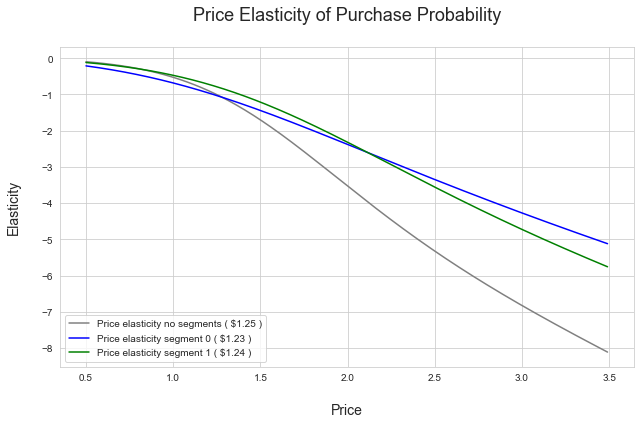

In [14]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.plot(price_range, pe_segment1, color='green', label="Price elasticity segment 1 ( $1.24 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

### $\hookrightarrow \color{red} {\text{Segment 2 - Fewer-Opportunities}}$

In [15]:
# Select only customers from segment 2 
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

# Prepare dependant and independant variables.
y = df_pa_segment_2['Incidence']
X = pd.DataFrame()
# Calculate average price segment 2
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

# Logistic regression model
model_incidence_segment2 = LogisticRegression(solver='sag')
model_incidence_segment2.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment2.coef_

# Predict purchase probability
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment2)
# Save values in hte dataframe
df_price_elasticities['PE_Segment_2'] = pe_segment2
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2
0,0.50,-0.096414,-0.211212,-0.119103,-0.030539
1,0.51,-0.100483,-0.217785,-0.123286,-0.032285
2,0.52,-0.104679,-0.224464,-0.127561,-0.034118
3,0.53,-0.109004,-0.231253,-0.131932,-0.036040
4,0.54,-0.113463,-0.238151,-0.136398,-0.038056
...,...,...,...,...,...
295,3.45,-8.012504,-5.053260,-5.677480,-12.552399
296,3.46,-8.037752,-5.070120,-5.697630,-12.589351
297,3.47,-8.062966,-5.086960,-5.717743,-12.626285
298,3.48,-8.088147,-5.103783,-5.737819,-12.663203


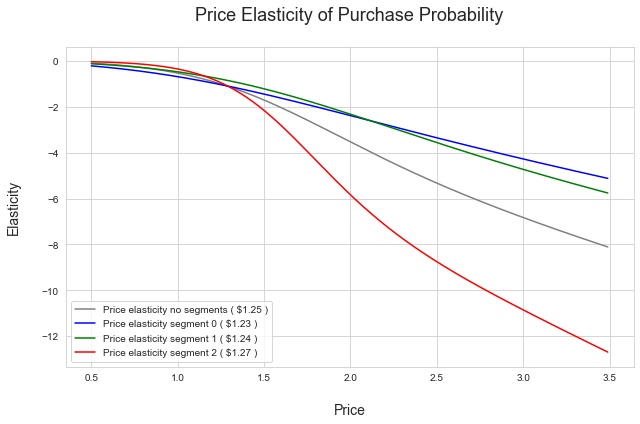

In [16]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.plot(price_range, pe_segment1, color='green', label="Price elasticity segment 1 ( $1.24 )")
plt.plot(price_range, pe_segment2, color='red', label="Price elasticity segment 2 ( $1.27 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

### $\hookrightarrow \color{orange} {\text{Segment 3 - Well-Off}}$

In [17]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]

# Prepare dependant and independant variables.
y = df_pa_segment_3['Incidence']
X = pd.DataFrame()
# Calculate average price segment 3
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver='sag')
model_incidence_segment3.fit(X, y)

# Retrieve beta (coefficient)
model_incidence_segment3.coef_

# Predict purchase probability
Y_segment_3 = model_incidence_segment3.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]

# Calculate price elasticity purchase probability
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range * \
                            ( 1- purchase_pr_segment3)
# Save values in hte dataframe
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096414,-0.211212,-0.119103,-0.030539,-0.168067
1,0.51,-0.100483,-0.217785,-0.123286,-0.032285,-0.172992
2,0.52,-0.104679,-0.224464,-0.127561,-0.034118,-0.177988
3,0.53,-0.109004,-0.231253,-0.131932,-0.036040,-0.183054
4,0.54,-0.113463,-0.238151,-0.136398,-0.038056,-0.188192
...,...,...,...,...,...,...
295,3.45,-8.012504,-5.053260,-5.677480,-12.552399,-4.021872
296,3.46,-8.037752,-5.070120,-5.697630,-12.589351,-4.036738
297,3.47,-8.062966,-5.086960,-5.717743,-12.626285,-4.051587
298,3.48,-8.088147,-5.103783,-5.737819,-12.663203,-4.066421


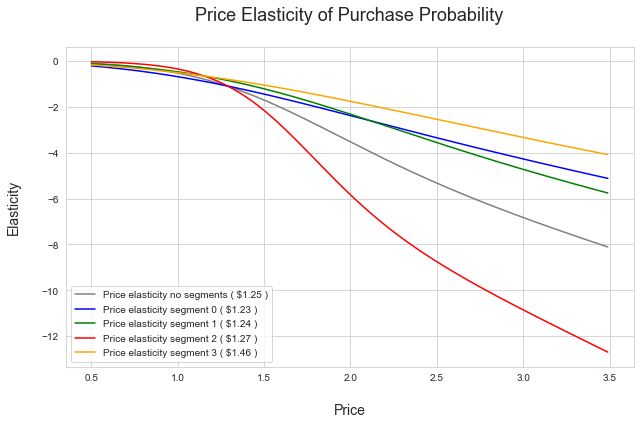

In [18]:
# Plot
plt.figure(figsize = (9, 6))

plt.plot(price_range, pe, color='grey', label="Price elasticity no segments ( $1.25 )")
plt.plot(price_range, pe_segment0, color='blue', label="Price elasticity segment 0 ( $1.23 )")
plt.plot(price_range, pe_segment1, color='green', label="Price elasticity segment 1 ( $1.24 )")
plt.plot(price_range, pe_segment2, color='red', label="Price elasticity segment 2 ( $1.27 )")
plt.plot(price_range, pe_segment3, color='orange', label="Price elasticity segment 3 ( $1.46 )")
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity of Purchase Probability\n', fontsize=18)

plt.tight_layout()
plt.legend(loc=3)
plt.show()

## Purchase Probability with Promotion Feature


We've now successfully completed the analysis by segments based on price, rest assured that **in any purchase analytics model you ever create, price will be the most prominent feature**. However, there might be other factors which affect a customer's decision whether to buy a product as well.

You may remember from our introductory lectures that one of the four PS was promotion. This basically means that a product's price could be temporarily reduced or other types of promotions such as display or feature, may come into play. So product promotion may affect purchase probability. Therefore, for this model will incorporate a promotion feature to see its effect on elasticity, as was the case for the brand.

We'll model using the entire data set and examine the importance of promotions for all customers, if you like, you can refine the model to reflect only a particular segment.

### Data Preparation

In [19]:
# Set variables
y = df_pa['Incidence']

X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [20]:
# We include a second promotion feature.
# We'd like to examine the effects of promotions on purchase probability.
# We calculate the average promotion rate across the five brands.
# We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [21]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.

model_incidence_promotion = LogisticRegression(solver='sag')
model_incidence_promotion.fit(X, y)
model_incidence_promotion.coef_

array([[-1.49396804,  0.56155408]])

## Price Elasticity with Promotion

In [22]:
# We create a data frame on which our model will predict.
# We need to include A price and promotion feature.
# First, we'll include the price range as the price feature.
# Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion \
                                        .rename(columns = {0: "Price_Range"})

In [23]:
# We'll calculate price elasticities of purchase probability when we assume
# there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [24]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [25]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) \
                                                                * (1 - promo)

In [26]:
# Update dataframe to include elasticities of purchase probability with promo feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096414,-0.211212,-0.119103,-0.030539,-0.168067,-0.125730
1,0.51,-0.100483,-0.217785,-0.123286,-0.032285,-0.172992,-0.129846
2,0.52,-0.104679,-0.224464,-0.127561,-0.034118,-0.177988,-0.134041
3,0.53,-0.109004,-0.231253,-0.131932,-0.036040,-0.183054,-0.138316
4,0.54,-0.113463,-0.238151,-0.136398,-0.038056,-0.188192,-0.142672
...,...,...,...,...,...,...,...
295,3.45,-8.012504,-5.053260,-5.677480,-12.552399,-4.021872,-4.861394
296,3.46,-8.037752,-5.070120,-5.697630,-12.589351,-4.036738,-4.879595
297,3.47,-8.062966,-5.086960,-5.717743,-12.626285,-4.051587,-4.897766
298,3.48,-8.088147,-5.103783,-5.737819,-12.663203,-4.066421,-4.915907


## Price Elasticity without Promotion

In [27]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no \
                                            .rename(columns = {0: "Price_Range"})

In [28]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [29]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [30]:
no_promo = Y_no_promo[: , 1]

In [31]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range \
                                                                  * (1- no_promo)

In [32]:
# Update df to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

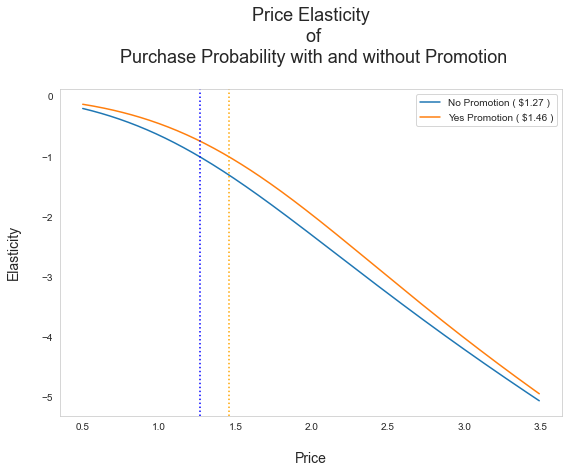

In [35]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
# Observe that purchase probability elasticity of customer is less elastic when there is promotion.

# This is an important insight for marketers, as according to our model people are more likely to buy a product if there is
# some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 
plt.figure(figsize = (9, 6))

plt.plot(price_range, price_elasticity_no_promo, label='No Promotion ( $1.27 )')
plt.plot(price_range, price_elasticity_promo, label='Yes Promotion ( $1.46 )')
plt.axvline(1.27, **{'lw': 1.5, 'alpha': 1, 'ls': ':', 'color': 'blue'})
plt.axvline(1.46, **{'lw': 1.5, 'alpha': 1, 'ls': ':', 'color': 'orange'})
plt.xlabel('\nPrice', fontsize=14)
plt.ylabel('Elasticity\n', fontsize=14)
plt.title('Price Elasticity\n of\n Purchase Probability with and without Promotion\n',
         fontsize=18)

plt.legend(loc=0)
plt.grid(False)
plt.show()

These two lines represent the elasticity of purchase probability, given maximum and given minimum promotional activity. This graph here tells us that the elasticity curve with promotion sits above its respective no promotion counterpart for the entire price range.

Additionally, if we see our dataframe, we can see that in elasticity for No Promotion ends at 1.27 dollar while for Yes Promotion at 1.46 dollars. That's a difference of almost 0.20 cents. So if a product has a regular price of 1.30 dollars, the purchase probability is elastic.

However, if a product cost 1.50 dollars on the regular (No Promotion) and its price is reduced to 1.30  dollars during a Promotion, then our analysis says that purchase probability is still inelastic at this point.

This may sound trivial, but it is not, think about it. People are more willing to buy products at promotional prices, be it because of the large discount signs in some stores, or just because psychologically people feel they're getting a bargain.

According to this model, if we could incorporate it, it would be more beneficial to have a higher original price and constant promotion rather than a lower original price.